In [155]:
import sys
import random
import warnings
import numpy as np
import torch
import torch.nn as nn  # PyTorch Lightning NN (neural network) module
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, default_collate
import torch.optim as optim 
from torchdata.dataloader2 import DataLoader2
import torchdata
import pytorch_lightning as pl
from pytorch_lightning.callbacks import DeviceStatsMonitor
from ceruleanml import plot
from ceruleanml import evaluation
from ceruleanml.data_pipeline import put_image_in_dict, get_src_pths_annotations, channel_first_norm_to_tensor, stack_tensors
from transformers import AutoModelForUniversalSegmentation, OneFormerConfig
import skimage.io as skio

if not sys.warnoptions:
    warnings.simplefilter("ignore")
# Set the random seed
seed=0 # we need to set this for torch datapipe separately
random.seed(seed)

Loading the train and validation set

In [3]:
train_dir = "../data/partitions/train_tiles_context_0/"
train_imgs, train_annotations = get_src_pths_annotations(train_dir)
val_dir = "../data/partitions/val_tiles_context_0/"
val_imgs, val_annotations = get_src_pths_annotations(val_dir)
test_dir = "../data/partitions/test_tiles_context_0/"

Setting up the datapipes

In [4]:
train_i_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[train_annotations])
train_l_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[train_annotations])
train_source_pipe_processed = (
    train_i_coco_pipe.get_scene_paths(train_dir)  # get source items from the collection
    .read_tiff()
)

In [5]:
train_labels_pipe_processed = (
    train_l_coco_pipe.decode_masks()
)

We'll train on random crops of masks to focus on the most informative parts of scene for more efficient training.

In [6]:
train_dp = (
    train_source_pipe_processed.zip(train_labels_pipe_processed)
    .random_crop_mask_if_exists(2000,2000)
    .map(channel_first_norm_to_tensor)
    .map(stack_tensors)
)

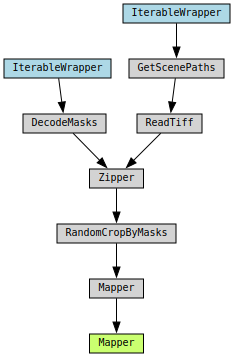

In [7]:
torchdata.datapipes.utils.to_graph(dp=train_dp)

Putting datapipes in a pytorch-lightning DataModule

In [140]:
import matplotlib.pyplot as plt

class OneFormerDataModule(pl.LightningDataModule):
    def __init__(self, train_dir, val_dir, test_dir, batch_size, num_workers, crop_size=2000):
        super().__init__()
        self.train_dir, self.val_dir, self.test_dir = train_dir, val_dir, test_dir
        self.bs = batch_size
        self.num_workers = num_workers
        self.crop_size = crop_size

    def setup(self, stage):
        if stage is not None:  # train/val/test/predict
            train_imgs, train_annotations = get_src_pths_annotations(self.train_dir)
            train_i_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[train_annotations])
            train_l_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[train_annotations])
            train_source_pipe_processed = (
                train_i_coco_pipe.get_scene_paths(self.train_dir)  # get source items from the collection
                .read_tiff()
            )
            train_labels_pipe_processed = (
                train_l_coco_pipe.decode_masks()
            )
            self.train_dp = (
                train_source_pipe_processed.zip(train_labels_pipe_processed)
                .random_crop_mask_if_exists(self.crop_size, self.crop_size)
                .map(channel_first_norm_to_tensor)
                .map(stack_tensors)
            )
            # TODO if val processing mirrors train processing, this could be factored out to a func
            val_imgs, val_annotations = get_src_pths_annotations(self.val_dir)
            val_i_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[val_annotations])
            val_l_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[val_annotations])
            val_source_pipe_processed = (
                val_i_coco_pipe.get_scene_paths(self.val_dir) # get source items from the collection
                .  read_tiff()
            )
            val_labels_pipe_processed = (
                val_l_coco_pipe.decode_masks()
            )
            self.val_dp = (
                val_source_pipe_processed.zip(val_labels_pipe_processed)
                .random_crop_mask_if_exists(self.crop_size,self.crop_size)
                .map(channel_first_norm_to_tensor)
                .map(stack_tensors)
            )

            test_imgs, test_annotations = get_src_pths_annotations(self.test_dir)
            test_i_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[test_annotations])
            test_l_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[test_annotations])
            test_source_pipe_processed = (
            test_i_coco_pipe.get_scene_paths(self.test_dir) # get source items from the collection
                .read_tiff()
                .map(put_image_in_dict)
                .map(channel_first_norm_to_tensor)
            )
            test_labels_pipe_processed = (
                test_l_coco_pipe.decode_masks()
            )
            self.test_dp = (
            test_source_pipe_processed.zip(test_labels_pipe_processed)
            .combine_src_label_dicts() # we don't crop for the test set TODO, do we also not crop for validation?
            .map(channel_first_norm_to_tensor)
            .map(stack_tensors)
            )

    def graph_dp(self):
        return torchdata.datapipes.utils.to_graph(dp=self.train_dp)

    def show_batch(self, channel=0):
        """
        channel 0 - vv radar
        channel 1 infra distance
        channel 2 historical vessel traffic

        """
        assert channel in [0,1,2]

        def closest_factors(n):
            factor1 = int(n**0.5)
            factor2 = n // factor1
            while factor1 * factor2 != n:
                factor1 -= 1
                factor2 = n // factor1
            return factor1, factor2

        nrows, ncols = closest_factors(self.bs)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
        
        for item, ax in zip(self.train_dp, fig.axes):
            if channel == 0:
                vv_db_units = np.log10(np.array(item["image"][channel,:,:])) * 10
            else:
                vv_db_units = np.array(item["image"][channel,:,:])
            vv_db_units[vv_db_units == -np.inf] = np.nan
            min_value = np.nanpercentile(vv_db_units, 5)
            max_value = np.nanpercentile(vv_db_units, 95)
            rescaled = (vv_db_units - min_value) / (max_value - min_value)
            im = ax.imshow(rescaled)
            
            # Create an individual colorbar for the current image
            cbar = fig.colorbar(im, ax=ax, shrink=0.7)
            
            # Set the number of ticks on the colorbar
            cbar.locator = MaxNLocator(nbins=5)
            cbar.update_ticks()

            # Format the tick labels
            tick_formatter = FuncFormatter(lambda x, pos: f'{min_value + x * (max_value - min_value):.2f}')
            cbar.ax.yaxis.set_major_formatter(tick_formatter)

        plt.tight_layout()

    def train_dataloader(self):
        return DataLoader(dataset=self.train_dp.batch(self.bs), batch_size=None)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_dp.batch(self.bs), batch_size=None)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_dp.batch(self.bs), batch_size=None)

    def predict_dataloader(self):
        return DataLoader(dataset=self.test_dp.batch(self.bs), batch_size=None)

In [141]:
onef_dm = OneFormerDataModule(train_dir, val_dir, test_dir, batch_size=4, num_workers=1, crop_size=2000)

In [142]:
onef_dm.setup(stage="train") #what's the purpose of stage?

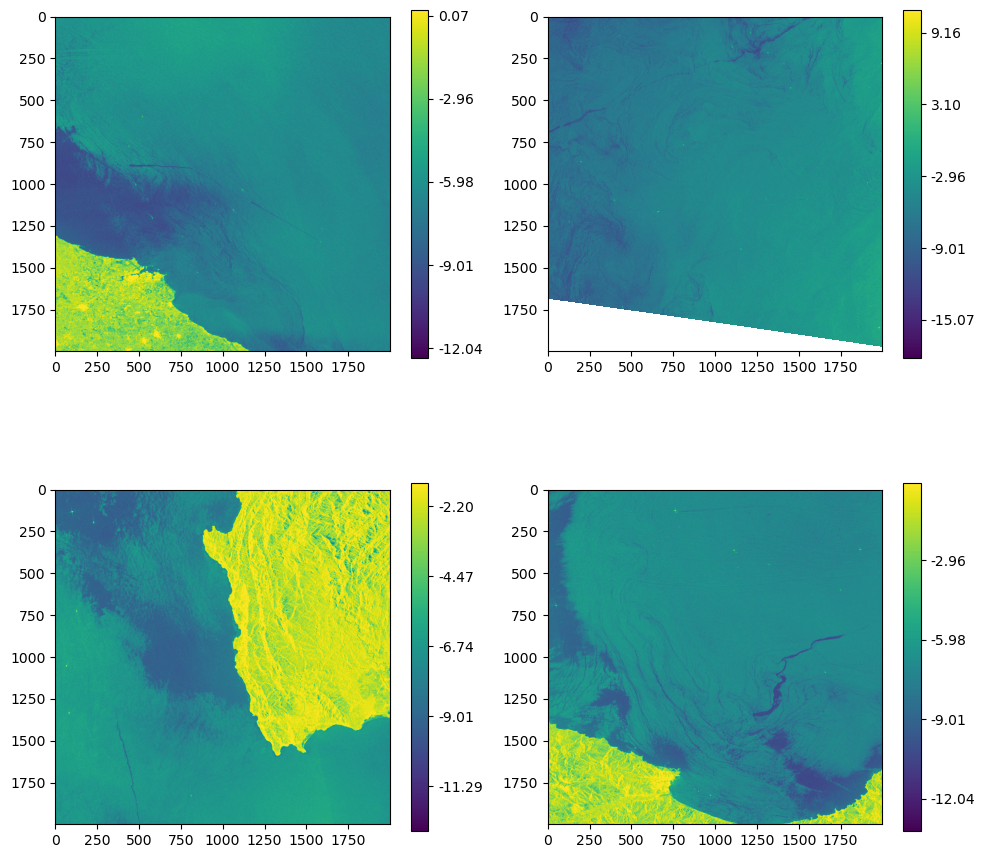

In [143]:
from matplotlib.ticker import MaxNLocator, FuncFormatter

onef_dm.show_batch(0)

In [144]:
for data in train_dp:
    print(data['image'].shape)
    break

torch.Size([3, 2000, 2000])


In [148]:
for data in onef_dm.train_dataloader():
    print(data[0]['image'].shape)
    break


torch.Size([3, 2000, 2000])


In [160]:
from transformers.models.oneformer.modeling_oneformer import OneFormerLoss

In [162]:
OneFormerLoss??

Init signature:
OneFormerLoss(
    num_classes: int,
    matcher: transformers.models.oneformer.modeling_oneformer.OneFormerHungarianMatcher,
    weight_dict: Dict[str, float],
    eos_coef: float,
    num_points: int,
    oversample_ratio: float,
    importance_sample_ratio: float,
    contrastive_temperature: float = None,
)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
par

In [ ]:
class Backbone(nn.Module):
    def __init__(
        self, model_name, in_chans, num_classes, pretrained, global_pool, drop_rate
    ):
        super().__init__()
        # loads from huggingface if not downloaded
        
        #by default the above method sets eval mode, set to training
        self.backbone.train()

    def forward(self, xb):
        return self.backbone(xb)

class OneFormerModel(pl.LightningModule):
    def __init__(
        self,
        model_name,
        in_chans=3,
        num_classes=3,
        pretrained=True,
        global_pool="avg",
        drop_rate=0.1,
        lr=1e-3,
    ):
        super().__init__()
        self.save_hyperparameters()  # saves all hparams as self.hparams
        self.config = OneFormerConfig.from_pretrained("shi-labs/oneformer_coco_swin_large", num_labels=num_classes)
        self.model = AutoModelForUniversalSegmentation.from_pretrained("shi-labs/oneformer_coco_swin_large", config = self.config)
        #by default the above method sets eval mode, set to training
        self.model.train()
        #setting up loss function
        self.oneformerloss = OneFormerLoss(num_classes=num_classes)

    def forward(self, xb):
        return self.model(xb)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        return optimizer

    def one_step(self, batch):
        xb, yb = batch["image"], batch["masks"]
        out = self(xb)
        loss = self.oneformerloss(out, yb) # a lot needs to be filled in here https://github.com/huggingface/transformers/blob/v4.28.1/src/transformers/models/oneformer/modeling_oneformer.py#L645
        _, pred = torch.max(out, dim=1)
        score = torch.sum(pred == yb) / len(pred)
        return loss, score

    def training_step(self, batch, batch_idx):
        loss, score = self.one_step(batch)
        self.log("trn_loss", loss, on_step=True, on_epoch=True, logger=True)
        self.log(
            "trn_score", score, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, score = self.one_step(batch)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_score", score, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        loss, score = self.one_step(batch)
        self.log("tst_loss", loss, prog_bar=True, logger=True)
        self.log("tst_score", score, prog_bar=True, logger=True)

In [122]:
t = AutoModelForUniversalSegmentation.from_pretrained("shi-labs/oneformer_coco_swin_large").model

In [127]:
AutoModelForUniversalSegmentation.from_pretrained??

Signature: AutoModelForUniversalSegmentation.from_pretrained(*model_args, **kwargs)
Docstring:
Instantiate one of the model classes of the library (with a universal image segmentation head) from a pretrained model.

The model class to instantiate is selected based on the `model_type` property of the config object (either
passed as an argument or loaded from `pretrained_model_name_or_path` if possible), or when it's missing, by
falling back to using pattern matching on `pretrained_model_name_or_path`:

    - **detr** -- [`DetrForSegmentation`] (DETR model)
    - **mask2former** -- [`Mask2FormerForUniversalSegmentation`] (Mask2Former model)
    - **maskformer** -- [`MaskFormerForInstanceSegmentation`] (MaskFormer model)
    - **oneformer** -- [`OneFormerForUniversalSegmentation`] (OneFormer model)

The model is set in evaluation mode by default using `model.eval()` (so for instance, dropout modules are
deactivated). To train the model, you should first set it back in training mode with `

In [ ]:
            model_name=model_name,
            in_chans=in_chans,
            num_classes=num_classes,
            pretrained=pretrained,
            global_pool=global_pool,
            drop_rate=drop_rate,

In [126]:
isinstance(t,nn.Module)

True

In [123]:
type(t)

transformers.models.oneformer.modeling_oneformer.OneFormerModel

TODO what are the model args??

transformers demo and model weight download

In [8]:
import transformers
from transformers import AutoProcessor




# the Auto API loads a OneFormerProcessor for us, based on the checkpoint
processor = AutoProcessor.from_pretrained("shi-labs/oneformer_coco_swin_large")

In [9]:
AutoProcessor.from_pretrained??

Signature: AutoProcessor.from_pretrained(pretrained_model_name_or_path, **kwargs)
Docstring:
Instantiate one of the processor classes of the library from a pretrained model vocabulary.

The processor class to instantiate is selected based on the `model_type` property of the config object (either
passed as an argument or loaded from `pretrained_model_name_or_path` if possible):

    - **align** -- [`AlignProcessor`] (ALIGN model)
    - **altclip** -- [`AltCLIPProcessor`] (AltCLIP model)
    - **blip** -- [`BlipProcessor`] (BLIP model)
    - **blip-2** -- [`Blip2Processor`] (BLIP-2 model)
    - **bridgetower** -- [`BridgeTowerProcessor`] (BridgeTower model)
    - **chinese_clip** -- [`ChineseCLIPProcessor`] (Chinese-CLIP model)
    - **clap** -- [`ClapProcessor`] (CLAP model)
    - **clip** -- [`CLIPProcessor`] (CLIP model)
    - **clipseg** -- [`CLIPSegProcessor`] (CLIPSeg model)
    - **flava** -- [`FlavaProcessor`] (FLAVA model)
    - **git** -- [`GitProcessor`] (GIT model)
    - **gr

In [10]:
# panoptic_inputs = processor(images=image, task_inputs=["panoptic"], return_tensors="pt")
# for k,v in panoptic_inputs.items():
#   print(k,v.shape)

In [11]:
model = AutoModelForUniversalSegmentation.from_pretrained("shi-labs/oneformer_coco_swin_large")

In [18]:
type(model)

transformers.models.oneformer.modeling_oneformer.OneFormerForUniversalSegmentation

In [19]:
dir(model.model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_auto_class',
 '_backward_compatibility_gradient_checkpointing',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_convert_head_mask_to_5d',
 '_create_repo',
 '_expand_inputs_for_generation',
 '_extract_past_from_model_output',
 '_forward_hooks',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_from_config',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_decoder_start_token_id',
 '_get_files_timestamps',
 '_get_logits_processor',
 '_get_logits_warpe

In [ ]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**panoptic_inputs)

In [ ]:

panoptic_segmentation = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
print(panoptic_segmentation.keys())

In [ ]:

from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))
        
    ax.legend(handles=handles)
    plt.savefig('cats_panoptic.png')

draw_panoptic_segmentation(**panoptic_segmentation)

Groundtruth datapipe with non cropped images. We will use these for inference with the trained model.

In [6]:
gt_train_dp = (train_dp
                    .map(evaluation.remap_gt_dict)
                    .map(evaluation.stack_boxes)
)

In [ ]:
from torchmetrics import detection

m = detection.mean_ap.MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[.5], rec_thresholds=None, max_detection_thresholds=None, class_metrics=True)

m.update(preds=[pred_dict_thresholded_nms], target=[test_sample])

from pprint import pprint
pprint(m.compute())